In [2]:
%matplotlib inline
import re
import sys
import math
import matplotlib
import seaborn
import numpy
from matplotlib import pyplot as plt
from collections import defaultdict

from evalutils import IntervalForest, populate_index_from_bed, compact
from evalutils import subset_variants_bed, load_kevlar_vcf, load_gatk_mvf, load_triodenovo_vcf
import kevlar

seaborn.set_context({'figure.figsize': (24, 12)})
matplotlib.rcParams['axes.labelsize'] = 16
matplotlib.rcParams['xtick.labelsize'] = 14
matplotlib.rcParams['ytick.labelsize'] = 14

In [3]:
def roc(calls, index, delta=10, fmt='vcf'):
    ncorrect = 0
    num_true_calls_per_false_call = list()
    for varcall in calls:
        if fmt == 'vcf':
            valid = index.query(varcall.seqid, varcall.position, delta=delta) != set()
        elif fmt == 'mvf':
            callindex, call = varcall
            valid = index.query(call['CHROM'], call['POS'], delta=delta) != set()
        else:
            raise ValueError('unknown format "'+ fmt +'"')
        if valid:
            ncorrect += 1
            continue
        num_true_calls_per_false_call.append(ncorrect)
    if len(num_true_calls_per_false_call) == 0 or ncorrect > num_true_calls_per_false_call[-1]:
        num_true_calls_per_false_call.append(ncorrect)
    return num_true_calls_per_false_call

In [4]:
def doplot(axis, data, color, label, linestyle, symbol):
    if len(data) == 1:
        axis.plot(range(len(data)), data, symbol, color=color, label=label)
    else:
        axis.plot(range(len(data)), data, color=color, linestyle=linestyle, label=label)

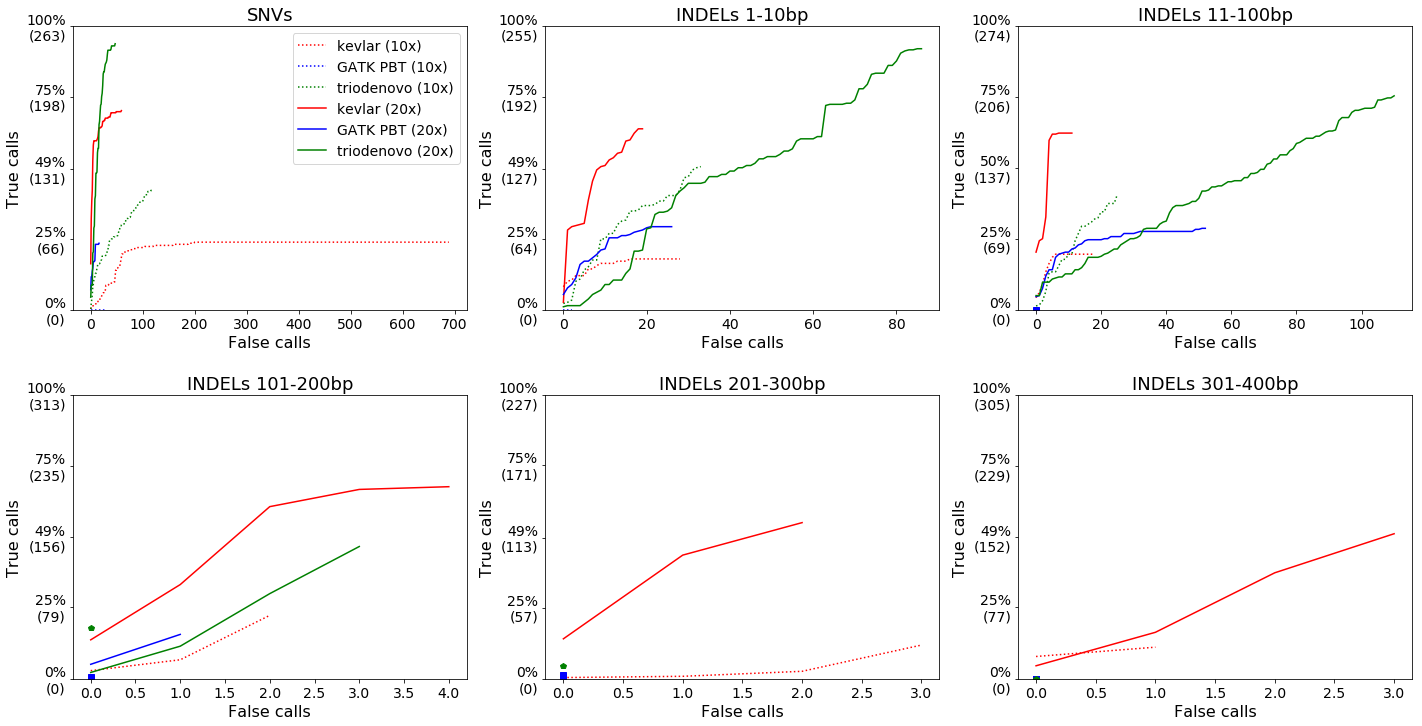

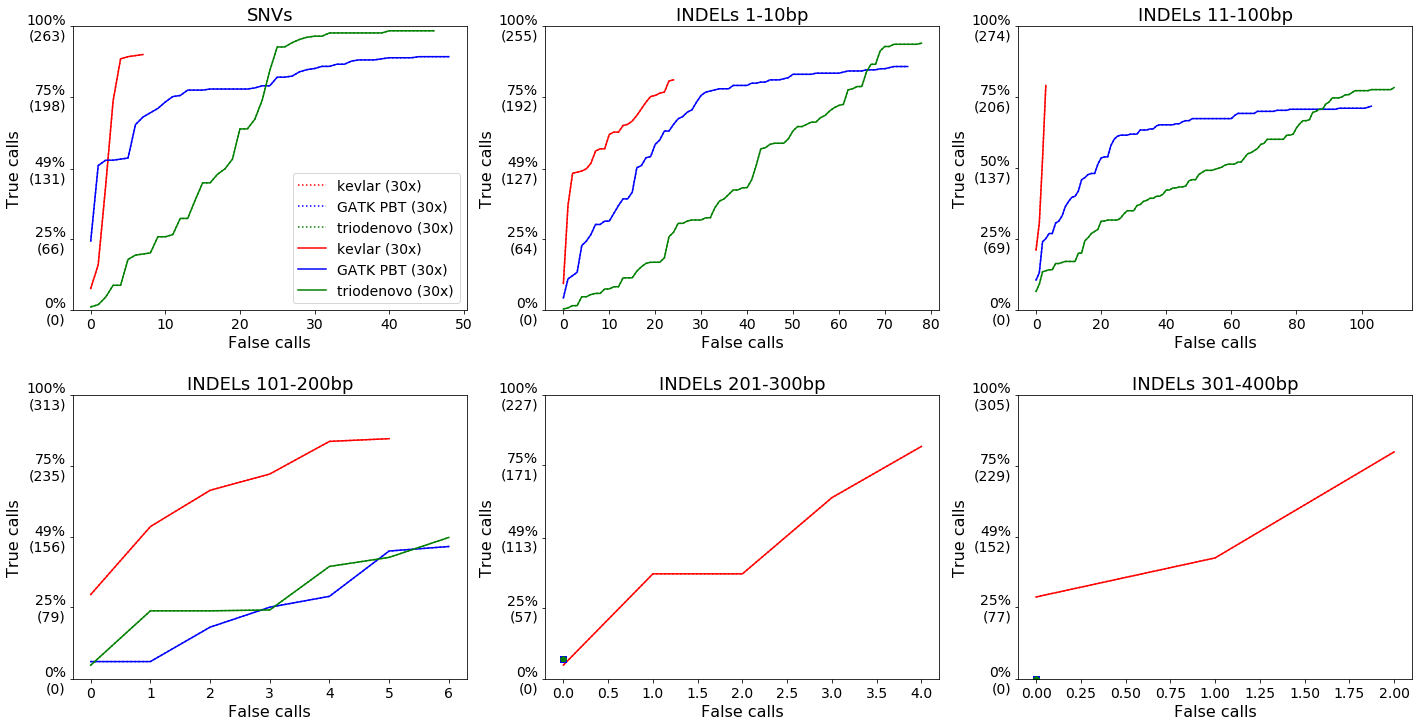

In [11]:
delta = 10
for cov1, cov2 in (('10', '20'), ('30', '30')):
    categories = [
        ('SNV', None, None, 'SNVs'),
        ('INDEL', 1, 10, 'INDELs 1-10bp'),
        ('INDEL', 11, 100, 'INDELs 11-100bp'),
        ('INDEL', 101, 200, 'INDELs 101-200bp'),
        ('INDEL', 201, 300, 'INDELs 201-300bp'),
        ('INDEL', 301, 400, 'INDELs 301-400bp'),
    ]
    fig, ((ax11, ax12, ax13), (ax21, ax22, ax23)) = plt.subplots(2, 3)
    axes = (ax11, ax12, ax13, ax21, ax22, ax23)
    seaborn.set_context({'figure.figsize': (24, 12)})
    
    for i, (category, axis) in enumerate(zip(categories, axes)):
        vartype, minlength, maxlength, label = category
        with kevlar.open('SimulatedVariants_chr17_hg38_markII.bed', 'r') as instream:
            variants = subset_variants_bed(instream, vartype, minlength, maxlength)
            index = populate_index_from_bed(variants)
        
            for cov, linestyle in zip((cov1, cov2), (':', '-')):
                kevlar_truecalls = roc(
                    load_kevlar_vcf(
                        'kevlar-newcalls-'+ cov +'x-k31.vcf.gz', index, delta=delta,
                        vartype=vartype, minlength=minlength, maxlength=maxlength
                    ),
                    index, delta=delta, fmt='vcf'
                )
                gatk_truecalls = roc(
                    load_gatk_mvf(
                        'JointCall-'+ cov +'x-PBT.mvf',
                        vartype=vartype, minlength=minlength, maxlength=maxlength
                    ).iterrows(),
                    index, delta=delta, fmt='mvf'
                )
                triodenovo_truecalls = roc(
                    load_triodenovo_vcf(
                        'JointCall-'+ cov +'x-TDN.vcf', cov=cov,
                        vartype=vartype, minlength=minlength, maxlength=maxlength,
                    ),
                    index, delta=delta, fmt='vcf'
                )
                doplot(axis, kevlar_truecalls, 'red', 'kevlar ({}x)'.format(cov), linestyle, 'o')
                doplot(axis, gatk_truecalls, 'blue', 'GATK PBT ({}x)'.format(cov), linestyle, 's')
                doplot(axis, triodenovo_truecalls, 'green', 'triodenovo ({}x)'.format(cov), linestyle, 'p')
            
            nvariants = len(index.trees['chr17'])
            ticknums = [0, math.ceil(nvariants * 0.25), int(nvariants * 0.5), math.ceil(nvariants * 0.75), nvariants]
            ticklabels = ['{:d}%\n({:d})'.format(int(tn / nvariants * 100), tn) for tn in ticknums]
            
            _ = axis.set_xlabel('False calls', fontsize=16)
            _ = axis.set_yticks(ticknums)
            _ = axis.set_yticklabels(ticklabels)
            _ = axis.set_ylabel('True calls', fontsize=16)
            _ = axis.set_ylim((0, nvariants))
            _ = axis.set_title(label, fontsize=18)
            if i == 0:
                _ = axis.legend(fontsize=14)
    
    _ = plt.subplots_adjust(hspace=0.3)
    _ = plt.savefig('three-callers-'+ cov +'x-combined-new.png', dpi=300)
    _ = plt.show()

In [6]:
!./evaluate.py --do-all - -

Caller Coverage          VarType Correct False Missing
    Kevlar       10              SNV      32   610     222
      GATK       10              SNV       1    41     253
TrioDenovo       10              SNV     122   103     132
    Kevlar       10     INDEL 1-10bp      35    21     243
      GATK       10     INDEL 1-10bp       0     4     278
TrioDenovo       10     INDEL 1-10bp     124    23     154
    Kevlar       10   INDEL 11-100bp      63    22     207
      GATK       10   INDEL 11-100bp       3     0     267
TrioDenovo       10   INDEL 11-100bp     117    26     153
    Kevlar       10  INDEL 101-200bp      52    13     220
      GATK       10  INDEL 101-200bp       1     0     271
TrioDenovo       10  INDEL 101-200bp      44     0     228
    Kevlar       10  INDEL 201-300bp      40     3     248
      GATK       10  INDEL 201-300bp       0     0     288
TrioDenovo       10  INDEL 201-300bp       1     0     287
    Kevlar       10  INDEL 301-400bp      38     0     246
 